<a href="https://www.kaggle.com/code/omarelhakim0/eeg-emotion-classification-on-seediv?scriptVersionId=283652705" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# TLDR:
* Model: DGCNN
* PreProcessing: None
* Data: DE features
* Balancing Technique: Weighted random sampler
* Labels: 0 (Neutral) , 1  Negative (Sad+ Fear) , 2 Positive (Happy)
* Test Accuracy: 82%

In [1]:
!pip install torch_scatter torcheeg torch_geometric -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.4/251.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.1/295.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 8.2 MB/s eta 0:00:00


In [2]:
# !rm -rf tmp_out

In [3]:
import torch
import torch.nn as nn
import torch.nn.utils as utils
from torch.utils.data import DataLoader, Subset,WeightedRandomSampler
from torcheeg.models import CCNN
from torcheeg import transforms
from torcheeg.transforms import ToGrid
from torcheeg.datasets import SEEDIVDataset,SEEDIVFeatureDataset
from torcheeg.datasets.constants import SEED_IV_CHANNEL_LOCATION_DICT
from torcheeg.transforms import ToG
from torcheeg.datasets.constants import SEED_IV_ADJACENCY_MATRIX
from torcheeg.models import DGCNN
import torch_geometric.loader as geom_loader # Special loader for graphs
import copy
import scipy.signal as signal
import random
import numpy as np

In [4]:
# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def map_emotions(y):
    # Input y is 0, 1, 2, or 3
    if y == 0: 
        return 0  # Neutral remains 0
    elif y == 1 or y == 2: 
        return 1  # Sad (1) and Fear (2) become Negative (1)
    elif y == 3: 
        return 2  # Happy (3) becomes Positive (2)
    return 0

In [6]:
dataset = SEEDIVFeatureDataset(
    io_path='./tmp_out/seed_iv_features',
    root_path='/kaggle/input/seed-iv/eeg_feature_smooth',
    feature=['de_LDS'], 
    num_worker=0,
    offline_transform=transforms.Compose([
        transforms.To2d(), 
        transforms.Lambda(lambda x: torch.tensor(x).float())]),
    label_transform=transforms.Compose([
        transforms.Select('emotion'),
        transforms.Lambda(map_emotions)
    ])
)

[2025-12-03 15:49:23] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ./tmp_out/seed_iv_features.
[2025-12-03 15:49:23] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:   0%|          | 0/45 [00:00<?, ?it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 0it [00:00, ?it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 1it [00:00,  3.34it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 13it [00:00, 40.18it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 25it [00:00, 64.51it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 37it [00:00, 80.95it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.mat]: 49it [00:00, 92.45it/s]
[RECORD /kaggle/input/seed-iv/eeg_feature_smooth/1/4_20151111.m

In [7]:
# Split by Trial ID
# SEED-IV has 24 trials (videos) per session.
# 80% of VIDEOS for training (19 videos), 20% for testing (5 videos).
all_trial_ids = list(range(1, 25))

random.seed(42)
test_trial_ids = random.sample(all_trial_ids, 5)
train_trial_ids = [t for t in all_trial_ids if t not in test_trial_ids]

df=dataset.info
train_indices = df[df['trial_id'].isin(train_trial_ids)].index.tolist()
test_indices = df[df['trial_id'].isin(test_trial_ids)].index.tolist()

# Create Subsets 
train_set = Subset(dataset, train_indices)
test_set = Subset(dataset, test_indices)

In [8]:
# 1. Get RAW labels from the DataFrame
y_train_indices = train_set.indices
raw_labels = dataset.info.iloc[y_train_indices]['emotion'].values

mapped_labels = [map_emotions(y) for y in raw_labels]

# 2. Count classes (Now it will be 3 classes)
class_counts = np.bincount(mapped_labels)
print(f"Corrected Class Counts: {class_counts}")

# 3. Compute Weight for each Class
class_weights = 1. / class_counts

# 4. Create Sample Weights
sample_weights = [class_weights[y] for y in mapped_labels]

# 5. Create Sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"Samples per class:{class_counts}")

Corrected Class Counts: [ 7050 15450  6915]
Samples per class:[ 7050 15450  6915]


In [9]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=False, sampler=sampler)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [10]:
model = DGCNN(
    in_channels=5,      # 5 Frequency Bands
    num_electrodes=62, 
    num_layers=2,       # Standard depth
    hid_channels=32,
    num_classes=3,
).to(device)

# Add weights to classes
# weights = torch.tensor([1.0, 0.9, 1.4]).to(device)
# weights = weights / weights.sum() * 3.0

# criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.25)
# criterion = nn.CrossEntropyLoss( label_smoothing=0.25)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)
# Scheduler: If validation loss doesn't go down for 3 epochs, cut LR by half
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Input Shape: torch.Size([64, 1, 62, 5])
Label Shape: torch.Size([64])

--- Label Distribution in this Batch ---
Neutral (0):  22 samples
Negative (1): 15 samples
Positive (2): 27 samples


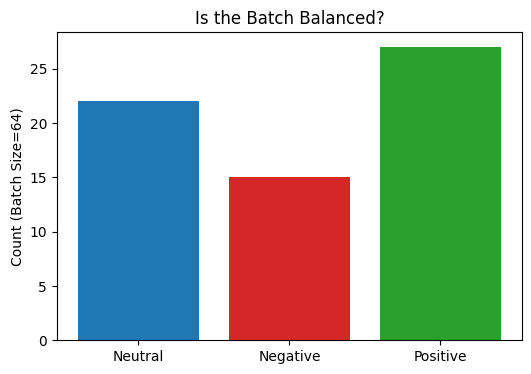

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# 1. Grab a single batch
# iter() creates an iterator, next() grabs the first 64 samples
data_iter = iter(train_loader)
X_batch, y_batch = next(data_iter)

# 2. Check Shapes
print(f"Input Shape: {X_batch.shape}") 
# Expected: torch.Size([64, 1, 62, 5]) if using To2d
print(f"Label Shape: {y_batch.shape}")

# 3. Verify Class Balance (The Sampler Test)
# Convert labels to numpy for counting
labels = y_batch.numpy()
unique, counts = np.unique(labels, return_counts=True)
label_dist = dict(zip(unique, counts))

print("\n--- Label Distribution in this Batch ---")
print(f"Neutral (0):  {label_dist.get(0, 0)} samples")
print(f"Negative (1): {label_dist.get(1, 0)} samples")
print(f"Positive (2): {label_dist.get(2, 0)} samples")

# 4. Visual Verification
# Ideally, you should see roughly ~21 samples for each class (64 / 3)
plt.figure(figsize=(6, 4))
plt.bar(['Neutral', 'Negative', 'Positive'], [label_dist.get(0, 0), label_dist.get(1, 0), label_dist.get(2, 0)], color=['#1f77b4', '#d62728', '#2ca02c'])
plt.title("Is the Batch Balanced?")
plt.ylabel("Count (Batch Size=64)")
plt.show()

In [12]:

# Early Stopping
patience = 15
counter = 0
best_val_acc = 0.0
best_model_state = None

for epoch in range(100):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        X, y = batch
        X = X.squeeze(1)
        X = X.to(device)
        y = y.to(device).long()
        
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    
    train_acc = 100 * correct / total
    
    # --- VALIDATION ---
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    
    with torch.no_grad():
        for batch in test_loader:
            X, y = batch
            
            # Same shape logic for validation
            X = X.squeeze(1)
            if X.shape[-1] == 62:
                X = X.transpose(1, 2)
            
            X = X.to(device)
            y = y.to(device).long()
            
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            val_total += y.size(0)
            val_correct += (predicted == y).sum().item()
            
    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}% | Val Acc={val_acc:.2f}% | Val Loss={avg_val_loss:.4f}")

    # --- EARLY STOPPING ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_dgcnn_final.pth')
        print(f"  --> New Best! {best_val_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("  --> Early Stopping.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Finished. Best Acc: {best_val_acc:.2f}%")

Epoch 1: Train Acc=65.56% | Val Acc=57.83% | Val Loss=0.9063
  --> New Best! 57.83%
Epoch 2: Train Acc=79.61% | Val Acc=64.49% | Val Loss=0.7855
  --> New Best! 64.49%
Epoch 3: Train Acc=83.19% | Val Acc=64.02% | Val Loss=0.7823
Epoch 4: Train Acc=86.77% | Val Acc=65.66% | Val Loss=0.7717
  --> New Best! 65.66%
Epoch 5: Train Acc=87.73% | Val Acc=72.34% | Val Loss=0.7077
  --> New Best! 72.34%
Epoch 6: Train Acc=89.09% | Val Acc=63.58% | Val Loss=0.8560
Epoch 7: Train Acc=91.19% | Val Acc=76.35% | Val Loss=0.6471
  --> New Best! 76.35%
Epoch 8: Train Acc=91.92% | Val Acc=76.04% | Val Loss=0.6198
Epoch 9: Train Acc=92.93% | Val Acc=74.08% | Val Loss=0.7375
Epoch 10: Train Acc=93.76% | Val Acc=79.79% | Val Loss=0.5587
  --> New Best! 79.79%
Epoch 11: Train Acc=93.91% | Val Acc=77.00% | Val Loss=0.5931
Epoch 12: Train Acc=94.24% | Val Acc=76.50% | Val Loss=0.7062
Epoch 13: Train Acc=95.35% | Val Acc=72.48% | Val Loss=0.7446
Epoch 14: Train Acc=95.70% | Val Acc=65.96% | Val Loss=0.9512
Epo

Generating confusion matrix...


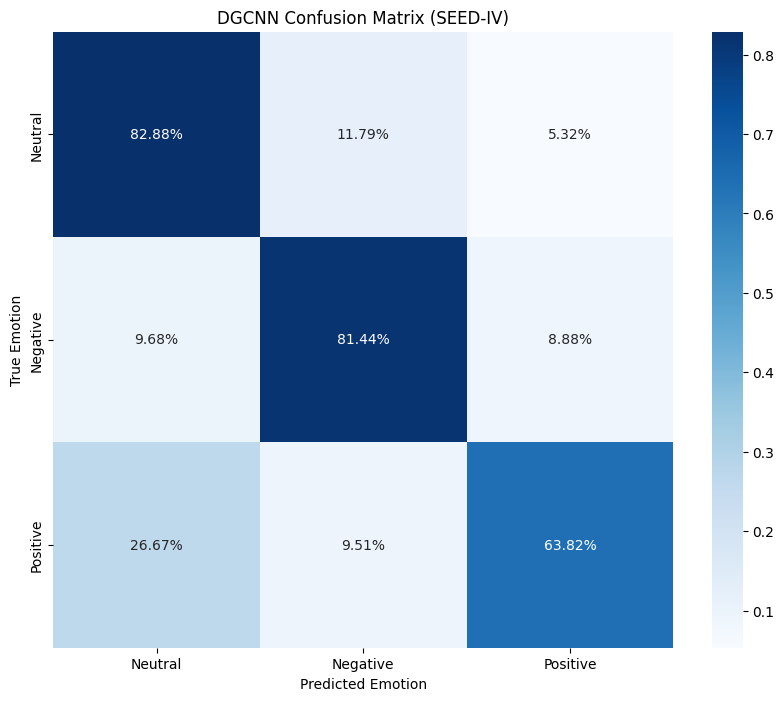

              precision    recall  f1-score   support

     Neutral       0.80      0.83      0.81      3120
    Negative       0.88      0.81      0.84      4020
    Positive       0.55      0.64      0.59      1020

    accuracy                           0.80      8160
   macro avg       0.74      0.76      0.75      8160
weighted avg       0.81      0.80      0.80      8160



In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Get Predictions for the entire Test Set
model.eval()
y_true = []
y_pred = []

print("Generating confusion matrix...")

with torch.no_grad():
    for batch in test_loader:
        X, y = batch
        
        # Apply the same Shape Fix logic
        X = X.squeeze(1)
        if X.shape[-1] == 62:
             X = X.transpose(1, 2)
             
        X = X.to(device)
        y = y.to(device)
        
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        
        y_true.extend(y.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 2. Define Emotion Labels
# 0: Neutral, 1: Sad, 2: Fear, 3: Happy
emotion_labels = ['Neutral', 'Negative', 'Positive']

# 3. Create Matrix
cm = confusion_matrix(y_true, y_pred)
# Normalize it to show Percentages instead of raw numbers
cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_pct, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.title('DGCNN Confusion Matrix (SEED-IV)')
plt.show()

# 5. Print Detailed Report
print(classification_report(y_true, y_pred, target_names=emotion_labels))